In [1]:
import numpy as np
import scipy as sp
import scipy.optimize

import matplotlib.pyplot as plt

strQx = "qx_US.txt"
strQy = "qy_US.txt"
strNx = "besta_US.txt"


strQx = "CH_qx.txt"
strQy = "CH_qy.txt"
strNx = "CH_bestand.txt"


def ReadDate(strqx,strqy,strbest):
    qxdict = dict() # qx(gender, time, age) returns (qx, nx, dx) # gender 0 man 1 woman
    QxRawData = np.loadtxt(strqx, skiprows=1)
    QyRawData = np.loadtxt(strqy, skiprows=1)
    BestRawData = np.loadtxt(strbest, skiprows=1)
    
    print("Processing Bestand")
    for i in range(len(BestRawData)):
        qxdict[(0,BestRawData[i,0],BestRawData[i,1])] = [None, BestRawData[i,2], None]
        qxdict[(1,BestRawData[i,0],BestRawData[i,1])] = [None, BestRawData[i,3], None]
    
    print("Processing Qx")
    for i in range(len(QxRawData)):
        t = QxRawData[i,0]
        x = QxRawData[i,1]
        qx = QxRawData[i,3]
        Nx = qxdict[(0,t,x)][1] 
        Dx = qx * Nx
        qxdict[(0,t,x)] = [qx, Nx, Dx]
 
    print("Processing Qy")
    for i in range(len(QyRawData)):
        t = QyRawData[i,0]
        x = QyRawData[i,1]
        qx = QyRawData[i,3]
        Nx = qxdict[(1,t,x)][1] 
        Dx = qx * Nx
        qxdict[(1,t,x)] = [qx, Nx, Dx]
    
    return qxdict

QxData = ReadDate(strQx,strQy,strNx)

Processing Bestand
Processing Qx
Processing Qy


Females plot
Results qx 
Age     Male (qx)  Female(qx) 
    0      0.0046      0.0034 
   10      0.0001      0.0001 
   20      0.0004      0.0001 
   30      0.0005      0.0002 
   40      0.0008      0.0005 
   50      0.0023      0.0015 
   60      0.0065      0.0037 
   70      0.0161      0.0088 
   80      0.0489      0.0303 
   90      0.1781      0.1408 
  100      0.4077      0.3810 



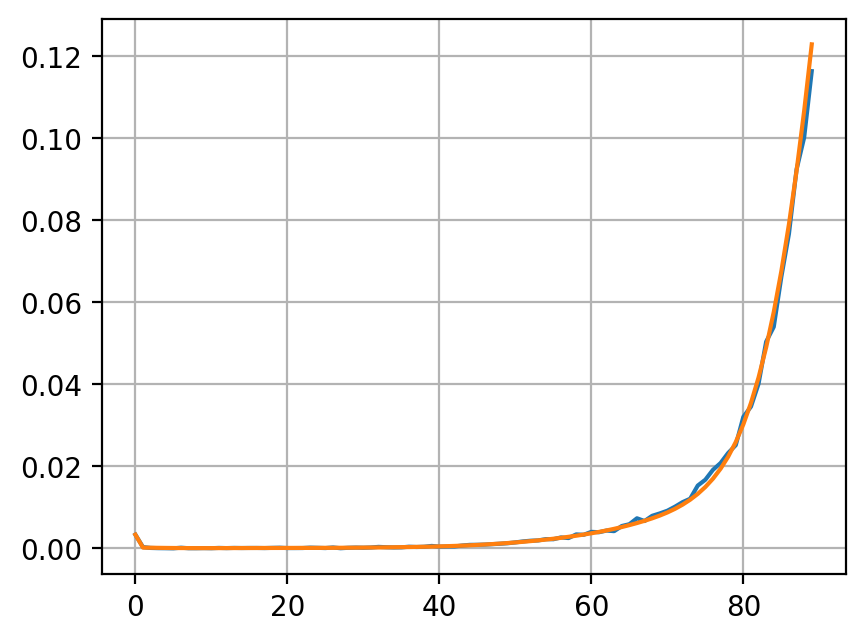

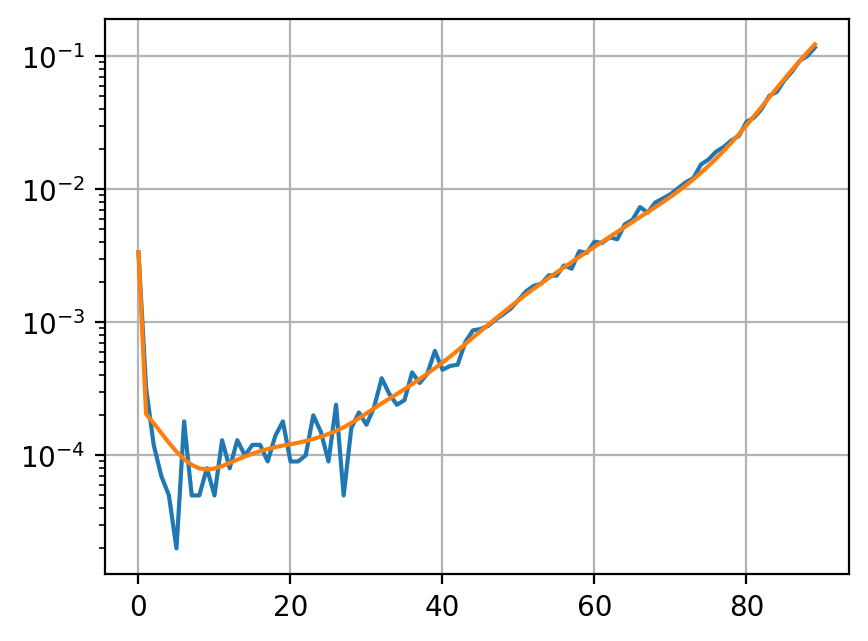

In [2]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import splu


def speyediff(N, d, format='csc'):
    """
    (utility function)
    Construct a d-th order sparse difference matrix based on 
    an initial N x N identity matrix
    
    Final matrix (N-d) x N
    """
    
    assert not (d < 0), "d must be non negative"
    shape     = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format=format)
    return spmat


def whittaker_smooth(y, lmbd, d = 2):
    """
    Implementation of the Whittaker smoothing algorithm,
    based on the work by Eilers [1].
    [1] P. H. C. Eilers, "A perfect smoother", Anal. Chem. 2003, (75), 3631-3636
    
    The larger 'lmbd', the smoother the data.
    For smoothing of a complete data series, sampled at equal intervals
    This implementation uses sparse matrices enabling high-speed processing
    of large input vectors
    
    ---------
    
    Arguments :
    
    y       : vector containing raw data
    lmbd    : parameter for the smoothing algorithm (roughness penalty)
    d       : order of the smoothing 
    
    ---------
    Returns :
    
    z       : vector of the smoothed data.
    """

    m = len(y)
    E = sparse.eye(m, format='csc')
    D = speyediff(m, d, format='csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z   

y = np.zeros(110)
qx2015 = np.zeros((3,110))

t=2015

for gender in range(2):
    y[0]= QxData[(gender,t,1)][0]
    for i in range(1,110):
        y[i]=QxData[(gender,t,i)][0]
        lam = 100
    y2 = whittaker_smooth(y, lam)
    y2[0]=QxData[(gender,t,0)][0]
    for i in range(110):
        qx2015[0, i]= i
        qx2015[gender+1,i]= min(1, max(0.0,y2[i]))
    y[0]= QxData[(gender,t,0)][0]

strOut = "Results qx \n"
strOut += "%-5s  %10s  %10s \n" %("Age","Male (qx)","Female(qx)")

for i in range(0,110,10):
    strOut+= "%5d  %10.4f  %10.4f \n" %(i,qx2015[1,i],qx2015[2,i])

print("Females plot")
    
plt.figure(1)
x=range(90)
plt.plot(x,y[x],x,y2[x])
plt.grid(True)

plt.figure(2)
x=range(90)
plt.semilogy(x,y[x],x,y2[x])
plt.grid(True)

print(strOut)

Females plot
Results qx 
Age    Male (lam)  Female(lam) 
    0     -0.0433     -0.0413 
   10     -0.0457     -0.0385 
   20     -0.0361     -0.0309 
   30     -0.0273     -0.0243 
   40     -0.0217     -0.0204 
   50     -0.0226     -0.0174 
   60     -0.0243     -0.0162 
   70     -0.0248     -0.0206 
   80     -0.0189     -0.0205 
   90     -0.0081     -0.0102 
  100     -0.0009     -0.0018 



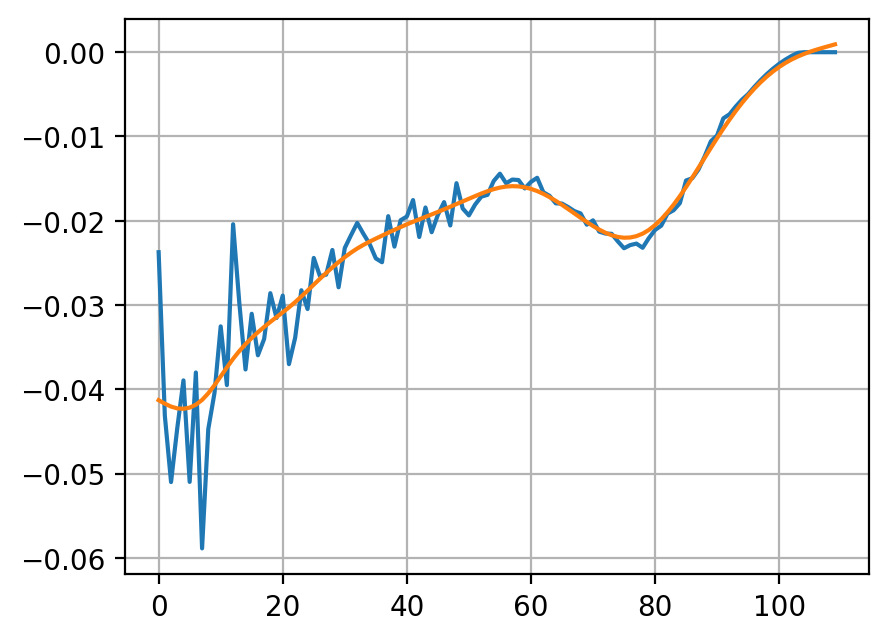

In [3]:
from scipy import stats
T=range(2015-40,2015)
lamdaraw = np.zeros(110)
lam2015 = np.zeros((3,110))
for gender in range(2):
    for i in range(110):
        myt = []
        qxlog = []
        for t in T:
            myt.append(t)
            qxlog.append(np.log(max(0.000001,QxData[(gender,t,i)][0])))
        slope, intercept, r_value, p_value, std_err = stats.linregress(myt,qxlog)
        lamdaraw[i] = min(slope,0)

    lam = 250
    
    mylambda = whittaker_smooth(lamdaraw, lam)
    for i in range(110):
        lam2015[0, i]= i
        lam2015[gender+1,i]=mylambda[i]
        if i>100: lam2015[gender+1,i]=0.

strOut = "Results qx \n"
strOut += "%-5s  %10s  %10s \n" %("Age","Male (lam)","Female(lam)")

for i in range(0,110,10):
    strOut+= "%5d  %10.4f  %10.4f \n" %(i,lam2015[1,i],lam2015[2,i])

print("Females plot")
    
    
plt.figure(3)
plt.plot(range(110),lamdaraw,range(110),mylambda)
plt.grid(True)

print(strOut)

In [4]:
import matplotlib.ticker as ticker

@ticker.FuncFormatter
def major_formatter(y, pos):
    #return f'[{x:6.4f}]'
    return("%6.4f"%(y))

def qxProj(gender,x,t,t0=2020):
    if x>= 110: return(1.)
    qxout = qx2015[gender+1,x] * np.exp((t-t0)*lam2015[gender+1,x])
    return(qxout)

def exProj(gender,x,t,t0=2015,omega=110,qx=qxProj):
    ex= 0
    for i in range(omega,x-1,-1):
        try:
            ex = 1 + (1-qx(gender,i,t+i-x,t0=t0))*ex
        except:
            ex = 0
    ex-=0.5
    return(ex)

def qxRaw(gender,x,t,t0=2015):
    try:
        return(QxData[gender,min(t,t0),x][0])
    except:
        return(1)

def QxTotal(gender,x,t,t0=2015):
    if( t <= t0): return(qxRaw(gender,x,t,t0=t0))
    return(qxProj(gender,x,t,t0=t0))
    
def dGT(x,t):
    return(qxProj(0,x,t))

def dPT2020(x,t):
    return(dGT(x,2020))

def dPT2030(x,t):
    return(dGT(x,2030))

def dPT2040(x,t):
    return(dGT(x,2040))

def dPT2050(x,t):
    return(dGT(x,2050))

def aex(x,qx,omega=110,i=0.02,t0=2020):
    dTemp = 1.
    for j in range(omega,x-1,-1):
        dTemp = (1-qx(j,t0+j-x))/(1+i)*dTemp + 1
    return(dTemp)

def tpx(x,t,qx,t0=2020):
    dTemp = 1.
    for j in range(x,x+t):
        dTemp *= (1-qx(j,t0+j-x))
    return(dTemp)


In [5]:
import numpy as np

x=np.zeros([6,100])
x[0,0] = 500000
x[1,0] = 2500000
x[2,0] = 12500000
x[3,0] = 25000000
x[4,0] = 20000000
x[5,0] = 10000000

ages =[40,50,60,70,80,90]

for i in range(99):
    for j in range(6):
        x[j,i] = x[j,0] * tpx(ages[j],i,dGT)
        
for i in range(0,50,10):
   print("Annuity year ",i+2020)
   print(x[:,i])
    
resGt =np.zeros([6,100])
resPt =np.zeros([6,100])
resPtPlus =np.zeros([6,100])
resDelta = np.zeros([6,100])
PNL = np.zeros([6,100])

for i in range(99):
    for j in range(6):
        resGt[j,i] = x[j,i] * aex(ages[j]+i,dGT,omega=110,i=0.02,t0=2020+i)
        dQx = dPT2020
        if i>= 10: dQx = dPT2030
        if i>= 20: dQx = dPT2040
        if i>= 30: dQx = dPT2050
        resPt[j,i] = x[j,i] * aex(ages[j]+i,dQx,omega=110,i=0.02,t0=2020+i)
        resPtPlus[j,i] = x[j,i] * aex(ages[j]+i+1,dQx,omega=110,i=0.02,t0=2020+i+1)
for i in range(98):
    for j in range(6):
        dQx = dPT2020
        if i>= 10: dQx = dPT2030
        if i>= 20: dQx = dPT2040
        if i>= 30: dQx = dPT2050
        PNL[j,i+1] =resPtPlus[j,i]*(dGT(ages[j]+i,2020+i)-dQx(ages[j]+i,2020+i))


AllQx = [dPT2020,dPT2030,dPT2040,dPT2050]

    
for i in [10,20,30]:
    myInd = 0
    for j in range(6):
        resDelta[j,i] = x[j,i] * (aex(ages[j]+i,AllQx[myInd+1],omega=110,i=0.02,t0=2020+i) - aex(ages[j]+i,AllQx[myInd],omega=110,i=0.02,t0=2020+i))
    myInd += 1

bFull = True
        
for i in range(0,40,5):
    print("GT year ",i+2020)
    if bFull: print(resGt[:,i])
    print("sum:",sum(resGt[:,i]))
    print("PT year ",i+2020)
    if bFull: print(resPt[:,i])
    print("sum:",sum(resPt[:,i]))
    print("ResDelta ",i+2020)
    if bFull: print(resDelta[:,i])
    print("sum:",sum(resDelta[:,i]))
    print("PNL ",i+2020)
    if bFull: print(PNL[:,i])
    print("sum:",sum(PNL[:,i]))
        


Annuity year  2020
[  500000.  2500000. 12500000. 25000000. 20000000. 10000000.]
Annuity year  2030
[  493993.17507182  2416220.86094446 11424629.6008909  19615668.70324565
  7769492.22112613   387330.34777395]
Annuity year  2040
[4.80863019e+05 2.25264922e+06 9.41557202e+06 8.58633808e+06
 3.44624447e+05 3.46063156e+02]
Annuity year  2050
[4.55295678e+05 1.93047185e+06 4.56914112e+06 4.32674364e+05
 3.09724104e+02 0.00000000e+00]
Annuity year  2060
[4.02499948e+05 1.02430001e+06 2.59652727e+05 3.91118353e+02
 0.00000000e+00 0.00000000e+00]
GT year  2020
[1.51952191e+07 6.38042231e+07 2.49481732e+08 3.51181443e+08
 1.64959613e+08 4.07341775e+07]
sum: 885356408.2594979
PT year  2020
[1.42019040e+07 5.95742283e+07 2.34235773e+08 3.34413103e+08
 1.60506949e+08 4.04394914e+07]
sum: 843371448.6704826
ResDelta  2020
[0. 0. 0. 0. 0. 0.]
sum: 0.0
PNL  2020
[0. 0. 0. 0. 0. 0.]
sum: 0.0
GT year  2025
[1.41273090e+07 5.72394735e+07 2.10003283e+08 2.59438366e+08
 8.68215958e+07 8.63751380e+06]
sum

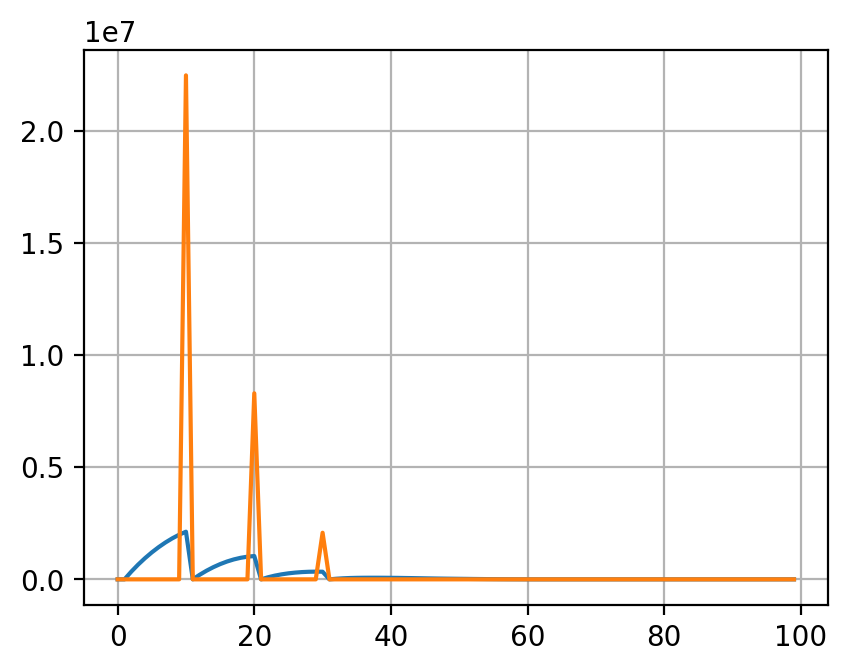

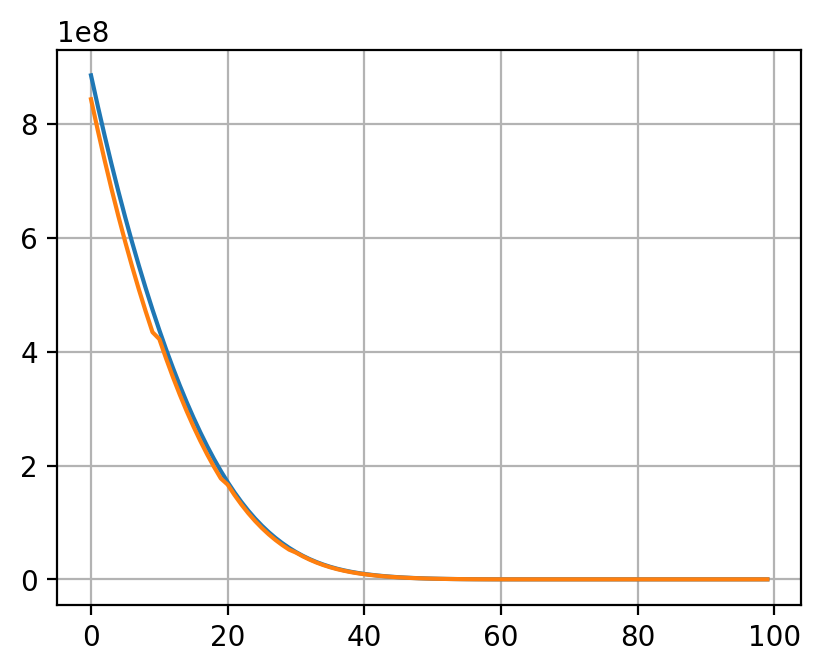

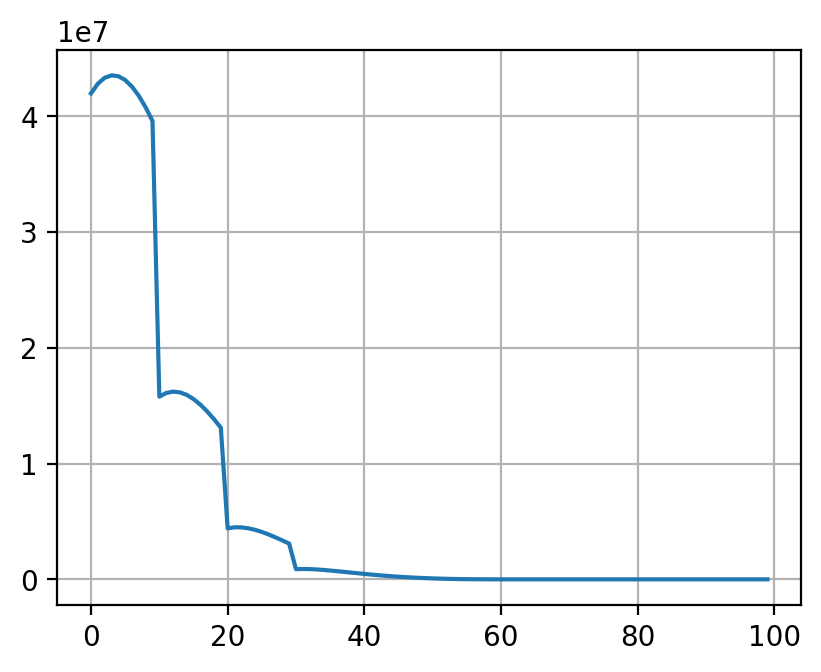

In [6]:
Rp=np.zeros(100)
DV=np.zeros(100)
DK1=np.zeros(100)
DK2=np.zeros(100)


for i in range(100):
    Rp[i] = sum(PNL[:,i])
    DV[i] = sum(resDelta[:,i])
    DK1[i]=sum(resGt[:,i])
    DK2[i]=sum(resPt[:,i])

    
plt.figure(1)
plt.plot(range(100),-Rp,range(100),DV)
plt.grid(True)


plt.figure(2)
plt.plot(range(100),DK1,range(100),DK2)
plt.grid(True)

plt.figure(3)
plt.plot(range(100),DK1-DK2)
plt.grid(True)

In [7]:
def PV(cf,i=0.02):
    dPV = 0
    for j in range(len(cf)):
        dPV += cf[j]*(1+i)**(-j)
    return(dPV)

print("%.0f"%sum(resGt[:,0]))
print("%.0f"%sum(resPt[:,0]))
print("%.0f"%PV(-Rp))
print("%.0f"%PV(DV))

print("%.0f"%(sum(resGt[:,0])-sum(resPt[:,0])-PV(-Rp)-PV(DV)))


885356408
843371449
17145027
25176705
-336773
